In [ ]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, to_date

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Seasonality_Analysis") \
    .config("spark.executor.memory", "2g") \
    .config("spark.driver.memory", "2g") \
    .config("spark.local.dir", "E:/SparkTemp") \
    .getOrCreate()

# Load Dataset from Local File System
data_path = "C:\\hadoop_doc\\Online_Retail.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

In [ ]:
# Data Cleaning and Preprocessing
df = df.dropna().filter(col("Quantity") > 0).filter(col("UnitPrice") > 0)
df = df.withColumn("TotalAmount", col("Quantity") * col("UnitPrice"))
df = df.withColumn("InvoiceDate", to_date(col("InvoiceDate")))

# Aggregating sales data by date
time_series_df = df.groupBy("InvoiceDate").agg(sum("TotalAmount").alias("Total_Sales"))



In [ ]:
# Convert Spark DataFrame to Pandas for Analysis
time_series_pd = time_series_df.toPandas()
time_series_pd["InvoiceDate"] = pd.to_datetime(time_series_pd["InvoiceDate"])  # Ensure datetime format
time_series_pd.set_index("InvoiceDate", inplace=True)
time_series_pd = time_series_pd.sort_index()

In [ ]:
# Aggregate Weekly and Monthly Sales
weekly_sales = time_series_pd.resample("W")["Total_Sales"].sum()
monthly_sales = time_series_pd.resample("M")["Total_Sales"].sum()

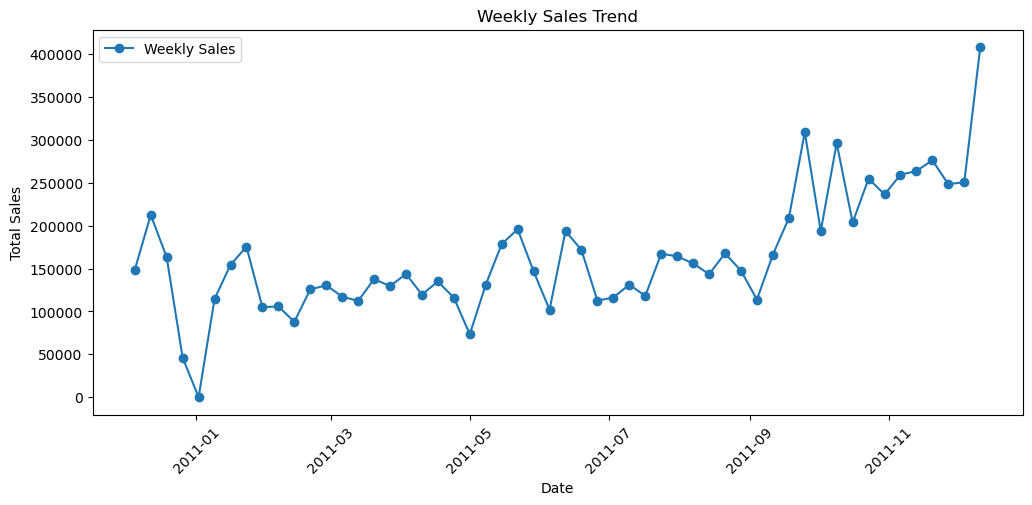

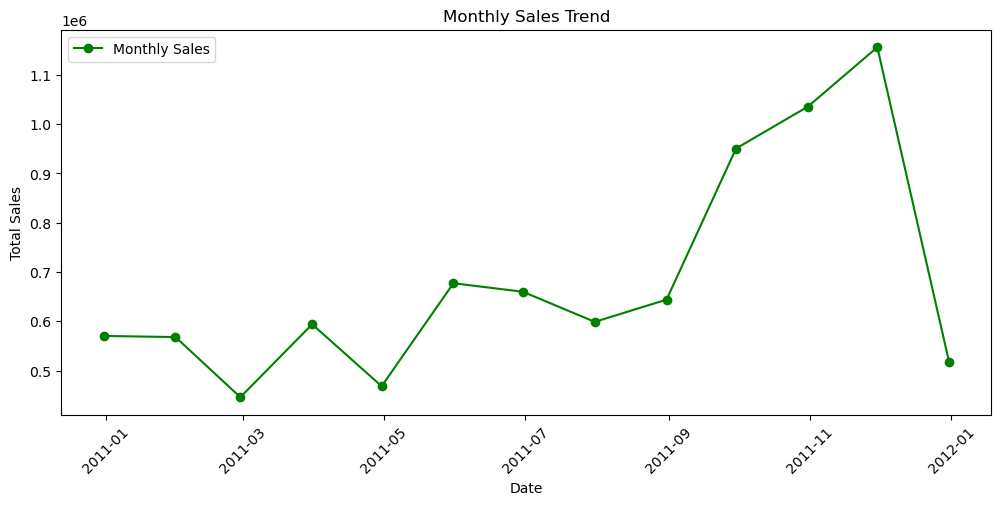

In [21]:

# Plot Weekly and Monthly Aggregation
plt.figure(figsize=(12, 5))
plt.plot(weekly_sales, marker="o", label="Weekly Sales")
plt.title("Weekly Sales Trend")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.legend()
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(monthly_sales, marker="o", label="Monthly Sales", color="green")
plt.title("Monthly Sales Trend")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.legend()
plt.xticks(rotation=45)
plt.show()

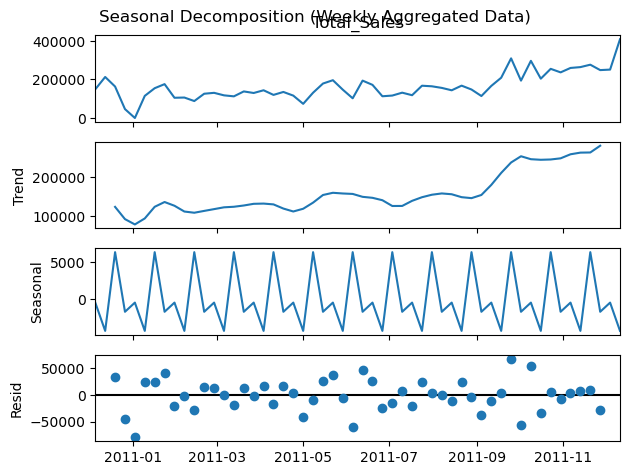

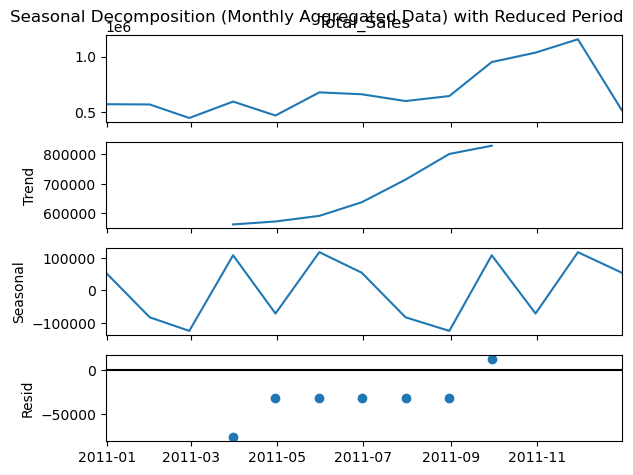

In [22]:

# Perform Seasonal Decomposition 
decompose_weekly = seasonal_decompose(weekly_sales, model="additive", period=4)
decompose_monthly = seasonal_decompose(monthly_sales, model="additive", period=6)

# Seasonal Decomposition for Weekly Data
decompose_weekly.plot()
plt.suptitle("Seasonal Decomposition (Weekly Aggregated Data)")
plt.show()

# Plott Seasonal Decomposition for Monthly Data
decompose_monthly.plot()
plt.suptitle("Seasonal Decomposition (Monthly Aggregated Data) with Reduced Period")
plt.show()


In [26]:
!pip install pmdarima


  Using cached Cython-3.0.11-cp311-cp311-win_amd64.whl.metadata (3.2 kB)
   ---------------------------------------- 0.0/614.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/614.7 kB ? eta -:--:--
    --------------------------------------- 10.2/614.7 kB ? eta -:--:--
   - ------------------------------------- 20.5/614.7 kB 131.3 kB/s eta 0:00:05
   - ------------------------------------- 30.7/614.7 kB 163.8 kB/s eta 0:00:04
   --- ----------------------------------- 51.2/614.7 kB 238.1 kB/s eta 0:00:03
   ----- --------------------------------- 92.2/614.7 kB 374.1 kB/s eta 0:00:02
   ------------------ --------------------- 286.7/614.7 kB 1.0 MB/s eta 0:00:01
   ------------------------------- -------- 481.3/614.7 kB 1.5 MB/s eta 0:00:01
   ---------------------------------------- 614.7/614.7 kB 1.7 MB/s eta 0:00:00
Using cached Cython-3.0.11-cp311-cp311-win_amd64.whl (2.8 MB)


In [7]:
# Extract Residuals for Outlier Detection
residuals = decompose_weekly.resid.dropna()

# Remove Outliers from Residuals using IQR Method
Q1 = residuals.quantile(0.25)
Q3 = residuals.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
cleaned_residuals = residuals[(residuals >= lower_bound) & (residuals <= upper_bound)]

# Reconstruct Cleaned Time Series
weekly_sales_cleaned = weekly_sales.copy()
weekly_sales_cleaned.loc[cleaned_residuals.index] += cleaned_residuals

# Apply Moving Average Smoothing
days_window = 3  
weekly_sales_cleaned = weekly_sales_cleaned.rolling(window=days_window, center=True).mean().dropna()

# Check for Stationarity Using ADF Test BEFORE Differencing
adf_result = adfuller(weekly_sales_cleaned.dropna())
print(f"ADF Statistic Before Differencing: {adf_result[0]}")
print(f"P-Value Before Differencing: {adf_result[1]}")
if adf_result[1] > 0.05:
    print("Data is non-stationary, applying differencing...")
    weekly_sales_cleaned = weekly_sales_cleaned.diff().dropna()
    # Check for Stationarity AFTER Differencing
    adf_result_after = adfuller(weekly_sales_cleaned.dropna())
    print(f"ADF Statistic After Differencing: {adf_result_after[0]}")
    print(f"P-Value After Differencing: {adf_result_after[1]}")
    if adf_result_after[1] > 0.05:
        print("Data is still non-stationary, consider higher differencing.")
    else:
        print("Data is now stationary.")
else:
    print("Data is already stationary, no differencing needed.")


ADF Statistic Before Differencing: 1.1789825447393527
P-Value Before Differencing: 0.9958374065862932
Data is non-stationary, applying differencing...
ADF Statistic After Differencing: -4.637253705269901
P-Value After Differencing: 0.00011021683755585066
Data is now stationary.


In [ ]:
# Splitting Data: Using first 11 months for training, last 4 weeks for validation
train_end_date = weekly_sales_cleaned.index[-5]  # Select the last month as validation period
train_data = weekly_sales_cleaned.loc[:train_end_date]
test_data = weekly_sales_cleaned.loc[train_end_date:]

# Optimizing ARIMA Hyperparameters using Auto-ARIMA
best_model = auto_arima(train_data, seasonal=True, m=4, stepwise=True, trace=True)
print(best_model.summary())


In [ ]:

# Training ARIMA Model on Best Parameters
p, d, q = best_model.order
model = ARIMA(train_data, order=(p, d, q))
target_model = model.fit()


In [ ]:
# Forecast for the next 4 weeks
predictions = target_model.forecast(steps=len(test_data))
forecast_df = pd.DataFrame({"InvoiceDate": test_data.index, "Predicted_Sales": predictions})
forecast_df.set_index("InvoiceDate", inplace=True)

In [ ]:
# Combining Actual and Predicted Data
test_data = test_data.copy()
test_data = test_data.to_frame()
test_data["Predicted_Sales"] = forecast_df["Predicted_Sales"]

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=1115.474, Time=0.69 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=1121.586, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=1125.178, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=1125.874, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=1119.666, Time=0.03 sec
 ARIMA(2,0,2)(0,0,1)[4] intercept   : AIC=1113.491, Time=0.35 sec
 ARIMA(2,0,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(2,0,2)(0,0,2)[4] intercept   : AIC=1115.428, Time=0.41 sec
 ARIMA(2,0,2)(1,0,0)[4] intercept   : AIC=1113.537, Time=0.37 sec
 ARIMA(2,0,2)(1,0,2)[4] intercept   : AIC=1115.048, Time=1.00 sec
 ARIMA(1,0,2)(0,0,1)[4] intercept   : AIC=1113.688, Time=0.34 sec
 ARIMA(2,0,1)(0,0,1)[4] intercept   : AIC=1129.464, Time=0.28 sec
 ARIMA(3,0,2)(0,0,1)[4] intercept   : AIC=1101.063, Time=0.66 sec
 ARIMA(3,0,2)(0,0,0)[4] intercept   : AIC=1102.545, Time=0.38 sec
 ARIMA(3,0,2)(1,0,1)[4] intercept   : 

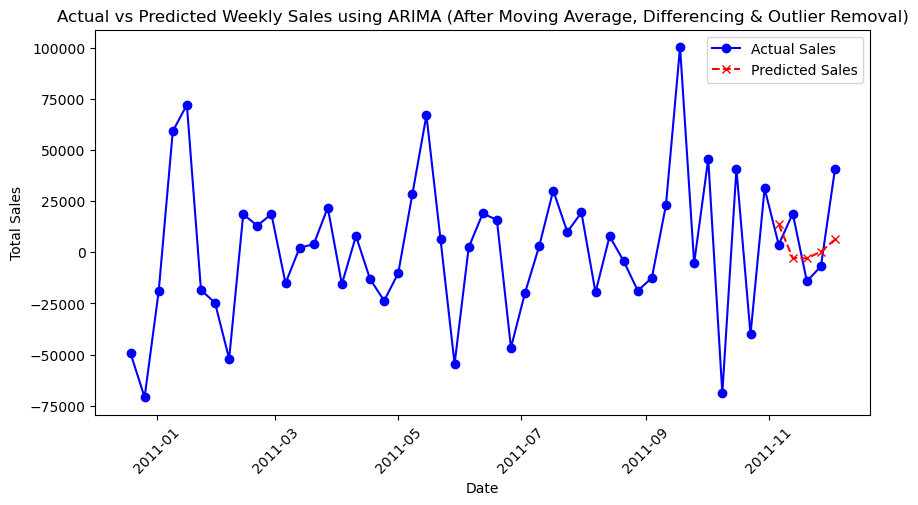

In [8]:
# Plotting Actual vs Predicted Weekly Sales
plt.figure(figsize=(10, 5))
plt.plot(weekly_sales_cleaned.index, weekly_sales_cleaned, label="Actual Sales", marker='o', color='blue')
plt.plot(test_data.index, test_data["Predicted_Sales"], label="Predicted Sales", linestyle="--", marker='x', color='red')
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.title("Actual vs Predicted Weekly Sales using ARIMA (After Moving Average, Differencing & Outlier Removal)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Stop Spark Session
spark.stop()
